# Gensim Word2Vec Tutorial

In this tutorial, we will learn how to use python gensim word2vec to train our word embedding. You can click here for more info about this python library <https://radimrehurek.com/gensim/>. 

This tutorial focuses on the use of the Word2Vec package from the Gensim libray. For more conceptual details, you can check my lecture slides. For more conceptual details, you can check my lecture slides. You can check here for more gensim word2vec model intro <https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-download-auto-examples-tutorials-run-word2vec-py>.

For the understanding of basic concepts of neural network on nlp, you can check Stanford CS224d: Deep Learning for NLP <http://web.stanford.edu/class/cs224n/>. Dr. Manning has a very intuitive, useful intro to word2vec. 

You will use 2000 NYT news article related to dynamic of collective action as raw texts. Please do not share this data set publicly. You can click here for more information about DOCA project <https://web.stanford.edu/group/collectiveaction/cgi-bin/drupal/>.

This tutorial is adapted from <https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial> and <https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-download-auto-examples-tutorials-run-word2vec-py>. You can check here for more details.

# Briefing about Word2Vec

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" alt="drawing" width="550"/>

Word2Vec was introduced in two papers, including [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf) and [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) between September and October 2013, by a team of researchers at Google. You can read these papers for more tech details. The Python implementation was in [Gensim](https://radimrehurek.com/gensim/index.html). 

Word2Vec assumes that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. Word2vec is a widely featured as a member of the “new wave” of machine learning algorithms based on neural networks, commonly referred to as “deep learning” (though word2vec itself is rather shallow). 

Using large amounts of unannotated plain text, word2vec learns relationships between words automatically. The output are vectors, one vector per word, with remarkable linear relationships that allow us to do things like:

vec(“king”) - vec(“man”) + vec(“woman”) =~ vec(“queen”)

You should be familiar with the bag-of-words model. This model transforms each document to a fixed-length vector of integers. For example, given the sentence:

John likes to watch movies. Mary likes movies too.

John also likes to watch football games. Mary hates football.

The model outputs the vectors:

[1, 2, 1, 1, 2, 1, 1, 0, 0, 0, 0]

[1, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1]

Each vector has 10 elements, where each element counts the number of times a particular word occurred in the document. The order of elements is arbitrary. In the example above, the order of the elements corresponds to the words: ["John", "likes", "to", "watch", "movies", "Mary", "too", "also", "football", "games", "hates"].

Bag-of-words models are surprisingly effective, but have several weaknesses.

First, they lose all information about word order: “John likes Mary” and “Mary likes John” correspond to identical vectors. 

Second, the model does not attempt to learn the meaning of the underlying words, and as a consequence, the distance between vectors doesn’t always reflect the difference in meaning. The Word2Vec model addresses this second problem.

Word2Vec is a more recent model that embeds words in a lower-dimensional vector space using a shallow neural network. The result is a set of word-vectors where vectors close together in vector space have similar meanings based on context, and word-vectors distant to each other have differing meanings. For example, strong and powerful would be close together and strong and Paris would be relatively far.

The are two versions of this model and Word2Vec class implements them both: Skip-grams (SG) and Continuous-bag-of-words (CBOW)

The Word2Vec Skip-gram model, for example, takes in pairs (word1, word2) generated by moving a window across text data, and trains a 1-hidden-layer neural network based on the synthetic task of given an input word, giving us a predicted probability distribution of nearby words to the input. A virtual one-hot encoding of words goes through a ‘projection layer’ to the hidden layer; these projection weights are later interpreted as the word embeddings. So if the hidden layer has 300 neurons, this network will give us 300-dimensional word embeddings.

Continuous-bag-of-words Word2vec is very similar to the skip-gram model. It is also a 1-hidden-layer neural network. The synthetic training task now uses the average of multiple input context words, rather than a single word as in skip-gram, to predict the center word. Again, the projection weights that turn one-hot words into averageable vectors, of the same width as the hidden layer, are interpreted as the word embeddings.

# Getting Started

Libraries used:
 * `spaCy`: https://spacy.io/usage/
 * `gensim`: https://radimrehurek.com/gensim/install.html
 * `scikit-learn`: http://scikit-learn.org/stable/install.html
 * `seaborn`: https://seaborn.pydata.org/installing.html
 
If your python environment does not have these libraries, you should use pip or conda to install these modules.

In [42]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

## The data
The DoCA NYT news articles raw texts were collected from ProQuest by matching news article titles with doca news article title. We only provide you 2000 articles for this tutorial. If your mac has limited RAM, you can then randomly select 1000 articles, but you can try to use 2K articles.

Again you can access the data set via this [link](https://yongjunzhang.com/files/tutorial/data_doca.csv).
You can also access doca data set here: <https://web.stanford.edu/group/collectiveaction/cgi-bin/drupal/node/21>
You can match article data with doca main dataset to retrieve more covariates. DOCA coded all news artcles. If you have any research ideas regarding using the DOCA raw NYT news articles, plz let me know. We can think about some research ideas maybe in the future.

# Preprocessing

We keep only two variables:
* `title_doca`: the news article title for doca in case that you want to match the data with doca_main data.
* `text`: the raw text for news articles related to protest

In [43]:
import os
os.getcwd() # check the working directory...
# in python, we use pandas to read and manipulate data...it is similar to R dataframe...
df = pd.read_csv('data_doca.csv').sample(n=2000).reset_index() # large text data
df.shape

(2000, 3)

In [44]:
df.head() # check the top 5 rows for a look

,index,title_doca,text
0,1432,FIRE RAZES SCHOOL THAT HELPED MARCH,FIRE RAZES SCHOOL THAT HELPED MARCH\nNew York ...
1,614,Antiwar Protests Erupt Across US,ANTIWAR PROTESTS ERUPT ACROSS U.S.: COLUMBIA R...
2,1461,3 NEGRO STUDENTS GET POLICE ESCORT,3 NEGRO STUDENTS GET POLICE ESCORT: PARENTS TE...
3,681,NEW ROCHELLE HIGH SHUT,New Rochelle High Shut\n\nSpecial to The New Y...
4,350,SPLIT AMONG JERSEY CUBANS IS POINTED UP BY BOM...,"Split Among, Jersey Cubans Is Pointed Up by Bo..."


Let us dive into one example. See raw text

In [45]:
df["text"][0]

"FIRE RAZES SCHOOL THAT HELPED MARCH\nNew York Times (1923-Current fle); Jun 25, 1966; ProQuest Historical Newspapers: The New York Times\n\nFIRE RAZES SCHOOL\nTHAT HELPED MARCH\n\nCARTHAGE, Miss., June 24\n(AP)—A rural Roman Catholic\nmission school for Negroes near\nhere was destroyed by fire early\ntoday. The Federal Bureau of\nInvestigation said it was looking into possible violations of\nFederal law.\n\nA staff member at the school,\nthe Rev. Luke Mikschl of New\nYork, said dynamite had been\nthrown on the school grounds\n“on several occasions” since it\nbegan classes for Negro adults\nlast February, No one was hurt\nby the blasts, he said.\n\nThe school, St. Joachim, was\noperated by the Trinitarian Missionaries. It was situated six\nmiles northwest of Carthage-—\na town half way between Mississippi's two cities of current\nracial tensions, Canton and Philadelphia, and had given refuge\nto civil rights marchers.\n\nLeake County Sheriff Russell\nEdwards could not be reached,\nbut 

Removing the missing values:

## Cleaning:
We need to remove those urgly punctuations
We are lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.
We use spacy library to do text processing. You can check here for more details <https://spacy.io/usage/processing-pipelines>

In [46]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed
## Josh comments: you need to download en_core_web_sm using "python -m spacy download en_core_web_sm"
def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(txt)

Let us removes non-alphabetic characters:

In [47]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['text'])

Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [48]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.46 mins


Put the results in a DataFrame to remove missing values and duplicates:

In [54]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(1980, 1)

## Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "new york" or "social movement" !

In [55]:
from gensim.models.phrases import Phrases, Phraser

As `Phrases()` takes a list of list of words as input:

In [56]:
article = [row.split() for row in df_clean['clean']]

Creates the relevant phrases from the list of articles:

In [57]:
phrases = Phrases(article, min_count=3)

INFO - 10:30:37: collecting all words and their counts
INFO - 10:30:37: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 10:30:38: collected 453893 word types from a corpus of 662842 words (unigram + bigrams) and 1980 sentences
INFO - 10:30:38: using 453893 counts as vocab in Phrases<0 vocab, min_count=3, threshold=10.0, max_vocab_size=40000000>


Phrases function Parameters

sentences (iterable of list of str, optional) – The sentences iterable can be simply a list, but for larger corpora, consider a generator that streams the sentences directly from disk/network, See BrownCorpus, Text8Corpus or LineSentence for such examples.

min_count (float, optional) – Ignore all words and bigrams with total collected count lower than this value.

threshold (float, optional) – Represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function, see the scoring parameter.

max_vocab_size (int, optional) – Maximum size (number of tokens) of the vocabulary. Used to control pruning of less common words, to keep memory under control. The default of 40M needs about 3.6GB of RAM. Increase/decrease max_vocab_size depending on how much available memory you have.

delimiter (str, optional) – Glue character used to join collocation tokens, should be a byte string (e.g. b’_’).

scoring ({'default', 'npmi', function}, optional) –

Specify how potential phrases are scored. scoring can be set with either a string that refers to a built-in scoring function, or with a function with the expected parameter names. Two built-in scoring functions are available by setting scoring to a string:

”default” - original_scorer().

”npmi” - npmi_scorer().

common_terms (set of str, optional) – List of “stop words” that won’t affect frequency count of expressions containing them. Allow to detect expressions like “bank_of_america” or “eye_of_the_beholder”.

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [58]:
bigram = Phraser(phrases)

INFO - 10:30:40: source_vocab length 453893
INFO - 10:30:43: Phraser built with 6551 phrasegrams


Transform the corpus based on the bigrams detected:

In [59]:
articles = bigram[article]

## Most Frequent Words:
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [60]:
word_freq = defaultdict(int)
for article in articles:
    for i in article:
        word_freq[i] += 1
len(word_freq)

45255

In [61]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['say',
 's',
 'new_york',
 'student',
 'mr',
 'group',
 'york_times',
 'school',
 'city',
 'black']

# Training the model
## Gensim Word2Vec Implementation:
We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

BEFORE WE DIVE INTO TRAINING OUR OWN MODEL, LET US SEE A DEMO FIRST

To see what Word2Vec can do, let’s download a pre-trained model and play around with it. We will fetch the Word2Vec model trained on part of the Google News dataset, covering approximately 3 million words and phrases. Downloading and loading it with Gensim takes minutes.
The model is approximately 2GB, so you’ll need a decent network connection and enough storage to proceed. Otherwise, skip ahead to the “Training Our Own Model” section below.

You can download google news dataset here <https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing>

In [62]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

INFO - 10:30:54: loading projection weights from GoogleNews-vectors-negative300.bin.gz
INFO - 10:31:24: loaded (3000000, 300) matrix from GoogleNews-vectors-negative300.bin.gz


A common operation is to retrieve the vocabulary of a model. That is trivial:

In [63]:
for i, word in enumerate(model.vocab):
    if i == 10:
        break
    print(word)

</s>
in
for
that
is
on
##
The
with
said


Word2Vec supports several word similarity tasks out of the box. You can see how the similarity intuitively decreases as the words get less and less similar.

In [64]:
pairs = [
    ('car', 'minivan'),   # a minivan is a kind of car
    ('car', 'bicycle'),   # still a wheeled vehicle
    ('car', 'airplane'),  # ok, no wheels, but still a vehicle
    ('car', 'cereal'),    # ... and so on
    ('car', 'communism'),
]
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model.similarity(w1, w2)))

'car'	'minivan'	0.69
'car'	'bicycle'	0.54
'car'	'airplane'	0.42
'car'	'cereal'	0.14
'car'	'communism'	0.06


Check here for a description of cosine similairty <https://en.wikipedia.org/wiki/Cosine_similarity>

In [65]:
print(model.most_similar(positive=['car', 'minivan'], topn=5)) #Print the 5 most similar words to “car” or “minivan”
print(model.doesnt_match(['fire', 'water', 'land', 'sea', 'air', 'car'])) #Print the one that does not belong in the sequence?


INFO - 10:31:48: precomputing L2-norms of word weight vectors


[('SUV', 0.853219211101532), ('vehicle', 0.8175784349441528), ('pickup_truck', 0.7763689160346985), ('Jeep', 0.7567334175109863), ('Ford_Explorer', 0.756571888923645)]
car


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [66]:
import multiprocessing

from gensim.models import Word2Vec

## Train our OWN model
1. `Word2Vec()`: In this first step, set up the parameters of the model one-by-one.
2. `.build_vocab()`: Here it builds the vocabulary from a sequence of sentences and thus initialized the model.
3. `.train()`: Finally, trains the model.

In [67]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

16

## The parameters:

sentences (iterable of iterables, optional) – The sentences iterable can be simply a list of lists of tokens, but for larger corpora, consider an iterable that streams the sentences directly from disk/network. See BrownCorpus, Text8Corpus or LineSentence in word2vec module for such examples. See also the tutorial on data streaming in Python. If you don’t supply sentences, the model is left uninitialized – use if you plan to initialize it in some other way.

corpus_file (str, optional) – Path to a corpus file in LineSentence format. You may use this argument instead of sentences to get performance boost. Only one of sentences or corpus_file arguments need to be passed (or none of them, in that case, the model is left uninitialized).

size (int, optional) – Dimensionality of the word vectors.

window (int, optional) – Maximum distance between the current and predicted word within a sentence.

min_count (int, optional) – Ignores all words with total frequency lower than this.

workers (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).

sg ({0, 1}, optional) – Training algorithm: 1 for skip-gram; otherwise CBOW.

hs ({0, 1}, optional) – If 1, hierarchical softmax will be used for model training. If 0, and negative is non-zero, negative sampling will be used.

negative (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.

ns_exponent (float, optional) – The exponent used to shape the negative sampling distribution. A value of 1.0 samples exactly in proportion to the frequencies, 0.0 samples all words equally, while a negative value samples low-frequency words more than high-frequency words. The popular default value of 0.75 was chosen by the original Word2Vec paper. More recently, in https://arxiv.org/abs/1804.04212, Caselles-Dupré, Lesaint, & Royo-Letelier suggest that other values may perform better for recommendation applications.

cbow_mean ({0, 1}, optional) – If 0, use the sum of the context word vectors. If 1, use the mean, only applies when cbow is used.

alpha (float, optional) – The initial learning rate.

min_alpha (float, optional) – Learning rate will linearly drop to min_alpha as training progresses.

seed (int, optional) – Seed for the random number generator. Initial vectors for each word are seeded with a hash of the concatenation of word + str(seed). Note that for a fully deterministically-reproducible run, you must also limit the model to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling. (In Python 3, reproducibility between interpreter launches also requires use of the PYTHONHASHSEED environment variable to control hash randomization).

max_vocab_size (int, optional) – Limits the RAM during vocabulary building; if there are more unique words than this, then prune the infrequent ones. Every 10 million word types need about 1GB of RAM. Set to None for no limit.

max_final_vocab (int, optional) – Limits the vocab to a target vocab size by automatically picking a matching min_count. If the specified min_count is more than the calculated min_count, the specified min_count will be used. Set to None if not required.

sample (float, optional) – The threshold for configuring which higher-frequency words are randomly downsampled, useful range is (0, 1e-5).

hashfxn (function, optional) – Hash function to use to randomly initialize weights, for increased training reproducibility.

iter (int, optional) – Number of iterations (epochs) over the corpus.

trim_rule (function, optional) –

Vocabulary trimming rule, specifies whether certain words should remain in the vocabulary, be trimmed away, or handled using the default (discard if word count < min_count). Can be None (min_count will be used, look to keep_vocab_item()), or a callable that accepts parameters (word, count, min_count) and returns either gensim.utils.RULE_DISCARD, gensim.utils.RULE_KEEP or gensim.utils.RULE_DEFAULT. The rule, if given, is only used to prune vocabulary during build_vocab() and is not stored as part of the model.

The input parameters are of the following types:
word (str) - the word we are examining

count (int) - the word’s frequency count in the corpus

min_count (int) - the minimum count threshold.

sorted_vocab ({0, 1}, optional) – If 1, sort the vocabulary by descending frequency before assigning word indexes. See sort_vocab().

batch_words (int, optional) – Target size (in words) for batches of examples passed to worker threads (and thus cython routines).(Larger batches will be passed if individual texts are longer than 10000 words, but the standard cython code truncates to that maximum.)

compute_loss (bool, optional) – If True, computes and stores loss value which can be retrieved using get_latest_training_loss().

callbacks (iterable of CallbackAny2Vec, optional) – Sequence of callbacks to be executed at specific stages during training.

In [76]:
w2v_model = Word2Vec(min_count=3,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     sg=0,
                     workers=cores-1)

## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [77]:
t = time()

w2v_model.build_vocab(articles, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:34:08: collecting all words and their counts
INFO - 10:34:08: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:34:09: collected 45255 word types from a corpus of 576654 raw words and 1980 sentences
INFO - 10:34:09: Loading a fresh vocabulary
INFO - 10:34:09: effective_min_count=3 retains 19177 unique words (42% of original 45255, drops 26078)
INFO - 10:34:09: effective_min_count=3 leaves 545256 word corpus (94% of original 576654, drops 31398)
INFO - 10:34:09: deleting the raw counts dictionary of 45255 items
INFO - 10:34:09: sample=6e-05 downsamples 1099 most-common words
INFO - 10:34:09: downsampling leaves estimated 346596 word corpus (63.6% of prior 545256)
INFO - 10:34:09: estimated required memory for 19177 words and 300 dimensions: 55613300 bytes
INFO - 10:34:09: resetting layer weights


Time to build vocab: 0.07 mins


## Training of the model:
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of articles;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [79]:
t = time()

w2v_model.train(articles, total_examples=w2v_model.corpus_count, epochs=100, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

WARNING - 10:35:12: Effective 'alpha' higher than previous training cycles
INFO - 10:35:12: training model with 15 workers on 19177 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 10:35:13: EPOCH 1 - PROGRESS: at 66.01% examples, 219724 words/s, in_qsize 0, out_qsize 1
INFO - 10:35:13: worker thread finished; awaiting finish of 14 more threads
INFO - 10:35:13: worker thread finished; awaiting finish of 13 more threads
INFO - 10:35:13: worker thread finished; awaiting finish of 12 more threads
INFO - 10:35:13: worker thread finished; awaiting finish of 11 more threads
INFO - 10:35:13: worker thread finished; awaiting finish of 10 more threads
INFO - 10:35:13: worker thread finished; awaiting finish of 9 more threads
INFO - 10:35:13: worker thread finished; awaiting finish of 8 more threads
INFO - 10:35:13: worker thread finished; awaiting finish of 7 more threads
INFO - 10:35:13: worker thread finished; awaiting finish of 6 more threads
INFO - 10:35

INFO - 10:35:22: EPOCH 7 - PROGRESS: at 66.01% examples, 222345 words/s, in_qsize 0, out_qsize 0
INFO - 10:35:23: worker thread finished; awaiting finish of 14 more threads
INFO - 10:35:23: worker thread finished; awaiting finish of 13 more threads
INFO - 10:35:23: worker thread finished; awaiting finish of 12 more threads
INFO - 10:35:23: worker thread finished; awaiting finish of 11 more threads
INFO - 10:35:23: worker thread finished; awaiting finish of 10 more threads
INFO - 10:35:23: worker thread finished; awaiting finish of 9 more threads
INFO - 10:35:23: worker thread finished; awaiting finish of 8 more threads
INFO - 10:35:23: worker thread finished; awaiting finish of 7 more threads
INFO - 10:35:23: worker thread finished; awaiting finish of 6 more threads
INFO - 10:35:23: worker thread finished; awaiting finish of 5 more threads
INFO - 10:35:23: worker thread finished; awaiting finish of 4 more threads
INFO - 10:35:23: worker thread finished; awaiting finish of 3 more thread

INFO - 10:35:32: worker thread finished; awaiting finish of 13 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 12 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 11 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 10 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 9 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 8 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 7 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 6 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 5 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 4 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 3 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 2 more threads
INFO - 10:35:32: worker thread finished; awaiting finish of 1 more threads
INFO - 10:35:32: work

INFO - 10:35:41: worker thread finished; awaiting finish of 11 more threads
INFO - 10:35:41: worker thread finished; awaiting finish of 10 more threads
INFO - 10:35:41: worker thread finished; awaiting finish of 9 more threads
INFO - 10:35:41: worker thread finished; awaiting finish of 8 more threads
INFO - 10:35:41: worker thread finished; awaiting finish of 7 more threads
INFO - 10:35:41: worker thread finished; awaiting finish of 6 more threads
INFO - 10:35:41: worker thread finished; awaiting finish of 5 more threads
INFO - 10:35:41: worker thread finished; awaiting finish of 4 more threads
INFO - 10:35:41: worker thread finished; awaiting finish of 3 more threads
INFO - 10:35:41: worker thread finished; awaiting finish of 2 more threads
INFO - 10:35:41: worker thread finished; awaiting finish of 1 more threads
INFO - 10:35:41: worker thread finished; awaiting finish of 0 more threads
INFO - 10:35:41: EPOCH - 19 : training on 576654 raw words (346753 effective words) took 1.5s, 231

INFO - 10:35:50: worker thread finished; awaiting finish of 9 more threads
INFO - 10:35:50: worker thread finished; awaiting finish of 8 more threads
INFO - 10:35:50: worker thread finished; awaiting finish of 7 more threads
INFO - 10:35:50: worker thread finished; awaiting finish of 6 more threads
INFO - 10:35:50: worker thread finished; awaiting finish of 5 more threads
INFO - 10:35:50: worker thread finished; awaiting finish of 4 more threads
INFO - 10:35:50: worker thread finished; awaiting finish of 3 more threads
INFO - 10:35:50: worker thread finished; awaiting finish of 2 more threads
INFO - 10:35:50: worker thread finished; awaiting finish of 1 more threads
INFO - 10:35:50: worker thread finished; awaiting finish of 0 more threads
INFO - 10:35:50: EPOCH - 25 : training on 576654 raw words (346462 effective words) took 1.5s, 229012 effective words/s
INFO - 10:35:51: EPOCH 26 - PROGRESS: at 64.39% examples, 216982 words/s, in_qsize 0, out_qsize 1
INFO - 10:35:51: worker thread f

INFO - 10:35:59: worker thread finished; awaiting finish of 7 more threads
INFO - 10:35:59: worker thread finished; awaiting finish of 6 more threads
INFO - 10:35:59: worker thread finished; awaiting finish of 5 more threads
INFO - 10:35:59: worker thread finished; awaiting finish of 4 more threads
INFO - 10:35:59: worker thread finished; awaiting finish of 3 more threads
INFO - 10:35:59: worker thread finished; awaiting finish of 2 more threads
INFO - 10:35:59: worker thread finished; awaiting finish of 1 more threads
INFO - 10:35:59: worker thread finished; awaiting finish of 0 more threads
INFO - 10:35:59: EPOCH - 31 : training on 576654 raw words (346503 effective words) took 1.5s, 231205 effective words/s
INFO - 10:36:00: EPOCH 32 - PROGRESS: at 66.01% examples, 221861 words/s, in_qsize 0, out_qsize 0
INFO - 10:36:00: worker thread finished; awaiting finish of 14 more threads
INFO - 10:36:00: worker thread finished; awaiting finish of 13 more threads
INFO - 10:36:00: worker thread

INFO - 10:36:08: worker thread finished; awaiting finish of 5 more threads
INFO - 10:36:08: worker thread finished; awaiting finish of 4 more threads
INFO - 10:36:08: worker thread finished; awaiting finish of 3 more threads
INFO - 10:36:08: worker thread finished; awaiting finish of 2 more threads
INFO - 10:36:08: worker thread finished; awaiting finish of 1 more threads
INFO - 10:36:08: worker thread finished; awaiting finish of 0 more threads
INFO - 10:36:08: EPOCH - 37 : training on 576654 raw words (346188 effective words) took 1.5s, 229191 effective words/s
INFO - 10:36:09: EPOCH 38 - PROGRESS: at 66.01% examples, 225179 words/s, in_qsize 0, out_qsize 0
INFO - 10:36:10: worker thread finished; awaiting finish of 14 more threads
INFO - 10:36:10: worker thread finished; awaiting finish of 13 more threads
INFO - 10:36:10: worker thread finished; awaiting finish of 12 more threads
INFO - 10:36:10: worker thread finished; awaiting finish of 11 more threads
INFO - 10:36:10: worker thre

INFO - 10:36:17: worker thread finished; awaiting finish of 3 more threads
INFO - 10:36:17: worker thread finished; awaiting finish of 2 more threads
INFO - 10:36:17: worker thread finished; awaiting finish of 1 more threads
INFO - 10:36:17: worker thread finished; awaiting finish of 0 more threads
INFO - 10:36:17: EPOCH - 43 : training on 576654 raw words (346534 effective words) took 1.5s, 230406 effective words/s
INFO - 10:36:18: EPOCH 44 - PROGRESS: at 67.78% examples, 223357 words/s, in_qsize 0, out_qsize 0
INFO - 10:36:19: worker thread finished; awaiting finish of 14 more threads
INFO - 10:36:19: worker thread finished; awaiting finish of 13 more threads
INFO - 10:36:19: worker thread finished; awaiting finish of 12 more threads
INFO - 10:36:19: worker thread finished; awaiting finish of 11 more threads
INFO - 10:36:19: worker thread finished; awaiting finish of 10 more threads
INFO - 10:36:19: worker thread finished; awaiting finish of 9 more threads
INFO - 10:36:19: worker thr

INFO - 10:36:26: worker thread finished; awaiting finish of 1 more threads
INFO - 10:36:26: worker thread finished; awaiting finish of 0 more threads
INFO - 10:36:26: EPOCH - 49 : training on 576654 raw words (346175 effective words) took 1.5s, 230116 effective words/s
INFO - 10:36:27: EPOCH 50 - PROGRESS: at 67.78% examples, 228378 words/s, in_qsize 0, out_qsize 0
INFO - 10:36:28: worker thread finished; awaiting finish of 14 more threads
INFO - 10:36:28: worker thread finished; awaiting finish of 13 more threads
INFO - 10:36:28: worker thread finished; awaiting finish of 12 more threads
INFO - 10:36:28: worker thread finished; awaiting finish of 11 more threads
INFO - 10:36:28: worker thread finished; awaiting finish of 10 more threads
INFO - 10:36:28: worker thread finished; awaiting finish of 9 more threads
INFO - 10:36:28: worker thread finished; awaiting finish of 8 more threads
INFO - 10:36:28: worker thread finished; awaiting finish of 7 more threads
INFO - 10:36:28: worker thr

INFO - 10:36:35: EPOCH - 55 : training on 576654 raw words (346603 effective words) took 1.5s, 231948 effective words/s
INFO - 10:36:36: EPOCH 56 - PROGRESS: at 66.01% examples, 225708 words/s, in_qsize 0, out_qsize 0
INFO - 10:36:37: worker thread finished; awaiting finish of 14 more threads
INFO - 10:36:37: worker thread finished; awaiting finish of 13 more threads
INFO - 10:36:37: worker thread finished; awaiting finish of 12 more threads
INFO - 10:36:37: worker thread finished; awaiting finish of 11 more threads
INFO - 10:36:37: worker thread finished; awaiting finish of 10 more threads
INFO - 10:36:37: worker thread finished; awaiting finish of 9 more threads
INFO - 10:36:37: worker thread finished; awaiting finish of 8 more threads
INFO - 10:36:37: worker thread finished; awaiting finish of 7 more threads
INFO - 10:36:37: worker thread finished; awaiting finish of 6 more threads
INFO - 10:36:37: worker thread finished; awaiting finish of 5 more threads
INFO - 10:36:37: worker thr

INFO - 10:36:46: EPOCH 62 - PROGRESS: at 66.01% examples, 224760 words/s, in_qsize 0, out_qsize 0
INFO - 10:36:46: worker thread finished; awaiting finish of 14 more threads
INFO - 10:36:46: worker thread finished; awaiting finish of 13 more threads
INFO - 10:36:46: worker thread finished; awaiting finish of 12 more threads
INFO - 10:36:46: worker thread finished; awaiting finish of 11 more threads
INFO - 10:36:46: worker thread finished; awaiting finish of 10 more threads
INFO - 10:36:46: worker thread finished; awaiting finish of 9 more threads
INFO - 10:36:46: worker thread finished; awaiting finish of 8 more threads
INFO - 10:36:46: worker thread finished; awaiting finish of 7 more threads
INFO - 10:36:46: worker thread finished; awaiting finish of 6 more threads
INFO - 10:36:46: worker thread finished; awaiting finish of 5 more threads
INFO - 10:36:46: worker thread finished; awaiting finish of 4 more threads
INFO - 10:36:46: worker thread finished; awaiting finish of 3 more threa

INFO - 10:36:55: worker thread finished; awaiting finish of 13 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 12 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 11 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 10 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 9 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 8 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 7 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 6 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 5 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 4 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 3 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 2 more threads
INFO - 10:36:55: worker thread finished; awaiting finish of 1 more threads
INFO - 10:36:55: work

INFO - 10:37:04: worker thread finished; awaiting finish of 11 more threads
INFO - 10:37:04: worker thread finished; awaiting finish of 10 more threads
INFO - 10:37:04: worker thread finished; awaiting finish of 9 more threads
INFO - 10:37:04: worker thread finished; awaiting finish of 8 more threads
INFO - 10:37:04: worker thread finished; awaiting finish of 7 more threads
INFO - 10:37:04: worker thread finished; awaiting finish of 6 more threads
INFO - 10:37:04: worker thread finished; awaiting finish of 5 more threads
INFO - 10:37:04: worker thread finished; awaiting finish of 4 more threads
INFO - 10:37:04: worker thread finished; awaiting finish of 3 more threads
INFO - 10:37:04: worker thread finished; awaiting finish of 2 more threads
INFO - 10:37:04: worker thread finished; awaiting finish of 1 more threads
INFO - 10:37:04: worker thread finished; awaiting finish of 0 more threads
INFO - 10:37:04: EPOCH - 74 : training on 576654 raw words (346970 effective words) took 1.5s, 231

INFO - 10:37:13: worker thread finished; awaiting finish of 9 more threads
INFO - 10:37:13: worker thread finished; awaiting finish of 8 more threads
INFO - 10:37:13: worker thread finished; awaiting finish of 7 more threads
INFO - 10:37:13: worker thread finished; awaiting finish of 6 more threads
INFO - 10:37:13: worker thread finished; awaiting finish of 5 more threads
INFO - 10:37:13: worker thread finished; awaiting finish of 4 more threads
INFO - 10:37:13: worker thread finished; awaiting finish of 3 more threads
INFO - 10:37:13: worker thread finished; awaiting finish of 2 more threads
INFO - 10:37:13: worker thread finished; awaiting finish of 1 more threads
INFO - 10:37:13: worker thread finished; awaiting finish of 0 more threads
INFO - 10:37:13: EPOCH - 80 : training on 576654 raw words (346953 effective words) took 1.4s, 243692 effective words/s
INFO - 10:37:14: EPOCH 81 - PROGRESS: at 67.78% examples, 223173 words/s, in_qsize 0, out_qsize 0
INFO - 10:37:15: worker thread f

INFO - 10:37:22: worker thread finished; awaiting finish of 7 more threads
INFO - 10:37:22: worker thread finished; awaiting finish of 6 more threads
INFO - 10:37:22: worker thread finished; awaiting finish of 5 more threads
INFO - 10:37:22: worker thread finished; awaiting finish of 4 more threads
INFO - 10:37:22: worker thread finished; awaiting finish of 3 more threads
INFO - 10:37:22: worker thread finished; awaiting finish of 2 more threads
INFO - 10:37:22: worker thread finished; awaiting finish of 1 more threads
INFO - 10:37:22: worker thread finished; awaiting finish of 0 more threads
INFO - 10:37:22: EPOCH - 86 : training on 576654 raw words (346950 effective words) took 1.5s, 233018 effective words/s
INFO - 10:37:23: EPOCH 87 - PROGRESS: at 67.78% examples, 222901 words/s, in_qsize 0, out_qsize 1
INFO - 10:37:24: worker thread finished; awaiting finish of 14 more threads
INFO - 10:37:24: worker thread finished; awaiting finish of 13 more threads
INFO - 10:37:24: worker thread

INFO - 10:37:31: worker thread finished; awaiting finish of 5 more threads
INFO - 10:37:31: worker thread finished; awaiting finish of 4 more threads
INFO - 10:37:31: worker thread finished; awaiting finish of 3 more threads
INFO - 10:37:31: worker thread finished; awaiting finish of 2 more threads
INFO - 10:37:31: worker thread finished; awaiting finish of 1 more threads
INFO - 10:37:31: worker thread finished; awaiting finish of 0 more threads
INFO - 10:37:31: EPOCH - 92 : training on 576654 raw words (346531 effective words) took 1.5s, 231595 effective words/s
INFO - 10:37:32: EPOCH 93 - PROGRESS: at 64.39% examples, 221733 words/s, in_qsize 0, out_qsize 1
INFO - 10:37:33: worker thread finished; awaiting finish of 14 more threads
INFO - 10:37:33: worker thread finished; awaiting finish of 13 more threads
INFO - 10:37:33: worker thread finished; awaiting finish of 12 more threads
INFO - 10:37:33: worker thread finished; awaiting finish of 11 more threads
INFO - 10:37:33: worker thre

INFO - 10:37:40: worker thread finished; awaiting finish of 3 more threads
INFO - 10:37:40: worker thread finished; awaiting finish of 2 more threads
INFO - 10:37:40: worker thread finished; awaiting finish of 1 more threads
INFO - 10:37:40: worker thread finished; awaiting finish of 0 more threads
INFO - 10:37:40: EPOCH - 98 : training on 576654 raw words (346317 effective words) took 1.5s, 231332 effective words/s
INFO - 10:37:41: EPOCH 99 - PROGRESS: at 66.01% examples, 228255 words/s, in_qsize 0, out_qsize 0
INFO - 10:37:42: worker thread finished; awaiting finish of 14 more threads
INFO - 10:37:42: worker thread finished; awaiting finish of 13 more threads
INFO - 10:37:42: worker thread finished; awaiting finish of 12 more threads
INFO - 10:37:42: worker thread finished; awaiting finish of 11 more threads
INFO - 10:37:42: worker thread finished; awaiting finish of 10 more threads
INFO - 10:37:42: worker thread finished; awaiting finish of 9 more threads
INFO - 10:37:42: worker thr

Time to train the model: 2.52 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

In [80]:
w2v_model.init_sims(replace=True)

INFO - 10:46:31: precomputing L2-norms of word weight vectors


# Storing and loading models¶

You’ll notice that training non-trivial models can take time. Once you’ve trained your model and it works as expected, you can save it to disk. That way, you don’t have to spend time training it all over again later.

You can store/load models using the standard gensim methods:

In [40]:
import tempfile
import gensim

with tempfile.NamedTemporaryFile(prefix='gensim-model-', delete=False) as tmp:
    temporary_filepath = tmp.name
    w2v_model.save(temporary_filepath)
    #
    # The model is now safely stored in the filepath.
    # You can copy it to other machines, share it with others, etc.
    #
# To load a saved model:

new_model = gensim.models.Word2Vec.load(temporary_filepath)

INFO - 10:26:30: saving Word2Vec object under /var/folders/cj/pyr99bvn3xd5qjy_m40ld9kc0000gn/T/gensim-model-qrmx7gdm, separately None
INFO - 10:26:30: not storing attribute vectors_norm
INFO - 10:26:30: not storing attribute cum_table
INFO - 10:26:30: saved /var/folders/cj/pyr99bvn3xd5qjy_m40ld9kc0000gn/T/gensim-model-qrmx7gdm
INFO - 10:26:30: loading Word2Vec object from /var/folders/cj/pyr99bvn3xd5qjy_m40ld9kc0000gn/T/gensim-model-qrmx7gdm
INFO - 10:26:30: loading wv recursively from /var/folders/cj/pyr99bvn3xd5qjy_m40ld9kc0000gn/T/gensim-model-qrmx7gdm.wv.* with mmap=None
INFO - 10:26:30: setting ignored attribute vectors_norm to None
INFO - 10:26:30: loading vocabulary recursively from /var/folders/cj/pyr99bvn3xd5qjy_m40ld9kc0000gn/T/gensim-model-qrmx7gdm.vocabulary.* with mmap=None
INFO - 10:26:30: loading trainables recursively from /var/folders/cj/pyr99bvn3xd5qjy_m40ld9kc0000gn/T/gensim-model-qrmx7gdm.trainables.* with mmap=None
INFO - 10:26:30: setting ignored attribute cum_tab

# Exploring the model

The main part of the model is w2v_model.wv, where “wv” stands for “word vectors”.

## Most similar to:

Here, we will ask our model to find the word most similar to "new"

Let's see what we get for the "new":

In [81]:
w2v_model.wv.most_similar(positive=["new"])

[('state', 0.3105401396751404),
 ('plan', 0.30601766705513),
 ('city', 0.2809823751449585),
 ('year', 0.2775835692882538),
 ('court', 0.2735474109649658),
 ('s', 0.2733498811721802),
 ('require', 0.2732350826263428),
 ('decision', 0.26876622438430786),
 ('contract', 0.26309239864349365),
 ('school', 0.2575671672821045)]

_A Note here:_<br>
We only use 2000 articles to train our word embeddings. 


Let's see what the bigram "new_york":

In [82]:
w2v_model.wv.most_similar(positive=["new_york"])

[('times_current', 0.7055099010467529),
 ('york_times', 0.6473978757858276),
 ('times', 0.6473656892776489),
 ('proquest_historical', 0.6095507144927979),
 ('newspaper_new', 0.6021746397018433),
 ('ps_bs', 0.5700998902320862),
 ('ew_york', 0.5552119016647339),
 ('current_fle', 0.5476503968238831),
 ('pg', 0.5311660766601562),
 ('proqu', 0.5239004492759705)]

In [83]:
w2v_model.wv.most_similar(positive=["activist"])

[('joseph_b', 0.27729183435440063),
 ('vienna', 0.2686992883682251),
 ('treaster', 0.2660790681838989),
 ('group', 0.24379265308380127),
 ('align', 0.23536896705627441),
 ('farm_union', 0.22481276094913483),
 ('support', 0.22475281357765198),
 ('laymen', 0.21873614192008972),
 ('policie', 0.2175137996673584),
 ('consumer_advocate', 0.2151505947113037)]

In [75]:
w2v_model.wv.most_similar(positive=["movement"])

[('belligerent', 0.2227466106414795),
 ('delaying', 0.20663030445575714),
 ('foreclosure', 0.20028670132160187),
 ('anonymously', 0.19974614679813385),
 ('vietcong', 0.1975529044866562),
 ('turnaround', 0.19336067140102386),
 ('inside_outside', 0.1912272870540619),
 ('sivertsen', 0.18977245688438416),
 ('burling', 0.18529903888702393),
 ('health_safety', 0.18120959401130676)]

Looks like it is making sense!

## Similarities:
Here, we will see how similar are two words to each other :

In [84]:
w2v_model.wv.similarity("activist", 'movement')

0.18649663

In [85]:
w2v_model.wv.similarity('activist', 'protest')

0.106794365


## Analogy difference:
Which word is to protest as activist is to movement?

In [86]:
w2v_model.wv.most_similar(positive=["activist", "movement"], negative=["protest"], topn=3)

[('reconstruction', 0.23501867055892944),
 ('goff', 0.23463329672813416),
 ('equate', 0.23000328242778778)]

In [87]:
w2v_model.wv.most_similar(positive=["black", "activist"], negative=["white"], topn=3)

[('laymen', 0.2714104652404785),
 ('palestine_liberation', 0.2692701816558838),
 ('group', 0.2545587718486786)]

# Visualising the Word Embeddings
The word embeddings made by the model can be visualised by reducing dimensionality of the words to 2 dimensions using tSNE.t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

Visualisations can be used to notice semantic and syntactic trends in the data.

Example:

> Semantic: words like cat, dog, cow, etc. have a tendency to lie close by

> Syntactic: words like run, running or cut, cutting lie close together.

> Vector relations like vKing - vMan = vQueen - vWoman can also be noticed.


In [90]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.<br>
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [91]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=5).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    


## 10 Most similar words vs. 5 Random words:
Let's compare where the vector representation of activist, the 10 most similar words from the model, as well as 5 random ones, lies in a 2D graph:

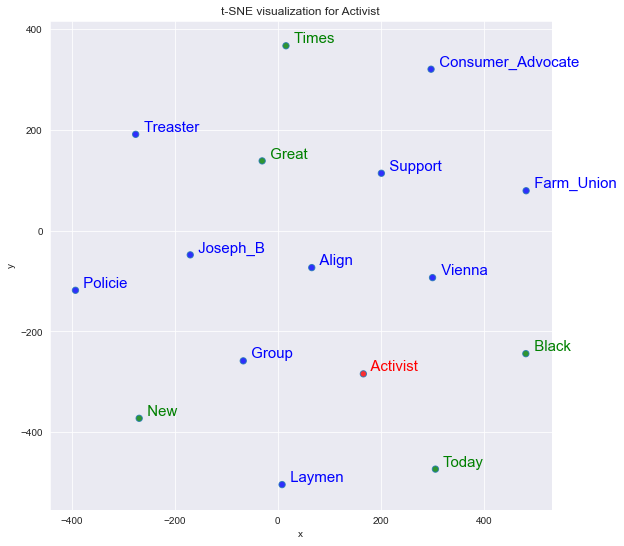

In [92]:
tsnescatterplot(w2v_model, 'activist', ['new', 'times', 'today', 'great', 'black'])

Interestingly, the 10 most similar words to Homer ends up around him, so does Apu and (sideshow) Bob, two recurrent characters.

## 10 Most similar words vs. 10 Most dissimilar

This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie:

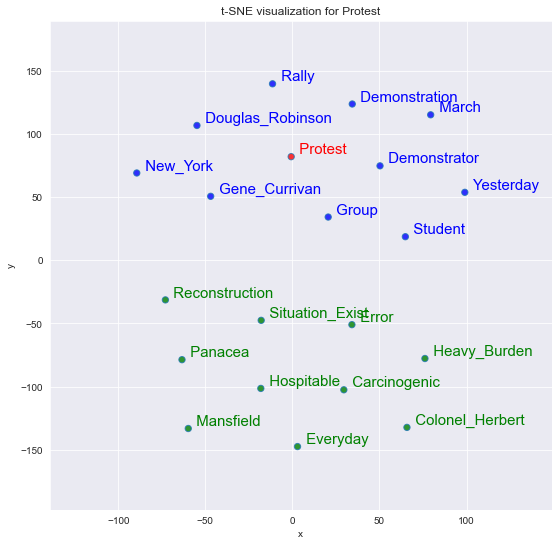

In [94]:
tsnescatterplot(w2v_model, 'protest', [i[0] for i in w2v_model.wv.most_similar(negative=["protest"])])

# Lab problem set released

Replicate our tutorial using NYT news article TITLE_DOCA instead of TEXT.
Please send me a screenshot for your extra credits.

# Materials for more in depths understanding:
* Word Embeddings introduction: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
* Another Word2Vec introduction: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
* Le and Mikolov in 2014 introduced the Doc2Vec algorithm, which usually outperforms such simple-averaging of Word2Vec vectors. The basic idea is: act as if a document has another floating word-like vector, which contributes to all training predictions, and is updated like other word-vectors, but we will call it a doc-vector. Gensim’s Doc2Vec class implements this algorithm. There are two implementations: Paragraph Vector - Distributed Memory (PV-DM) and Paragraph Vector - Distributed Bag of Words (PV-DBOW). PV-DM is analogous to Word2Vec CBOW. The doc-vectors are obtained by training a neural network on the synthetic task of predicting a center word based an average of both context word-vectors and the full document’s doc-vector. PV-DBOW is analogous to Word2Vec SG. The doc-vectors are obtained by training a neural network on the synthetic task of predicting a target word just from the full document’s doc-vector. (It is also common to combine this with skip-gram testing, using both the doc-vector and nearby word-vectors to predict a single target word, but only one at a time.) You can check here for more details. <https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py>

# Acknowledgements
* This tutorial is adapted from <https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial> and <https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-download-auto-examples-tutorials-run-word2vec-py>.

# End